## GP regression report-Aug 20th

In this report, we will compare the MSE and runtime of different approximation methods in both 1 dimensional and 2 dimensional case.

First we import the libraries we need

In [1]:
##  import packages ##
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import GPy as gpy
from IPython.display import display
import pylab as pb
from pylab import plot, title, figure, xlabel, ylabel, legend
import random
import time
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

### 1. Compare methods in 1-dimensional case

First, we draw 10000 data points from the function  $y=\sin \left( 2\pi x \right)$ on the interval [-50,50] plus some noise. Then, we use these data points to do full GP, approximate GP and FITC. 

In [3]:
##  draw 10000 data points ##
num_points = 10000
np.random.seed(101)
x = np.random.uniform(-50.,50.,(num_points,1))
y = np.sin(x*2*np.pi) + 0.3*np.random.randn(num_points,1)

Then, we do the full GP, approximate GP, and FITC respectively. This process is the same as what we did last time. The only difference is that the data points come from interval [-50,50] rather than [-3,3].

### 1.1 Full GP regression

In [10]:
##  find the best parameter for full GP  ##
kernel = gpy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
m_fullGP = gpy.models.GPRegression(x[0:1000],y[0:1000],kernel)
m_fullGP.optimize_restarts(num_restarts = 10)

##  do full GP regression  ##
kernel = gpy.kern.RBF(input_dim=1, variance=m_fullGP.rbf.variance[0], lengthscale=m_fullGP.rbf.lengthscale[0])
num=[500,1000,1500,2000,2500,3000,3500]
##  use two vectors to store MSE and time  ##
mse_fullGP=[]
time_fullGP=[]
for i in range(len(num)):
    start_time = time.time()
    m_fullGP = gpy.models.GPRegression(x[0:num[i]],y[0:num[i]],kernel)
    time_fullGP.append(time.time() - start_time)
    mse_fullGP.append((sum((m_fullGP.predict(x[0:num[i]])[0]-y[0:num[i]])**2))/num[i])

Optimization restart 1/10, f = 704.834169997
Optimization restart 2/10, f = 704.834169997
Optimization restart 3/10, f = 1142.17652749
Optimization restart 4/10, f = 704.834169997
Optimization restart 5/10, f = 704.834169998
Optimization restart 6/10, f = 1142.17652221
Optimization restart 7/10, f = 704.834169997
Optimization restart 8/10, f = 704.834169997
Optimization restart 9/10, f = 1142.17653973
Optimization restart 10/10, f = 704.834169997


### 1.2 Approximate GP regression(SD)
We use 70% of datapoints

In [11]:
kernel = gpy.kern.RBF(input_dim=1, variance=m_fullGP.rbf.variance[0], lengthscale=m_fullGP.rbf.lengthscale[0])
num=[500,1000,1500,2000,2500,3000,3500]
mse_SD=[]
time_SD=[]
np.random.seed(100)
for i in range(len(num)):
    ##  choose some data points randomly  ##
    index=random.sample(xrange(num[i]),int(num[i]*0.7))
    start_time = time.time()
    m_SD = gpy.models.GPRegression(x[index],y[index],kernel)
    time_SD.append(time.time() - start_time)
    mse_SD.append((sum((m_SD.predict(x[index])[0]-y[index])**2))/(num[i]*0.7))

### 1.3 FITC:
We use 300 inducing inputs to do FITC. 

Optimization restart 1/10, f = 759.727788094
Optimization restart 2/10, f = 1142.17654879
Optimization restart 3/10, f = 759.727788094
Optimization restart 4/10, f = 759.727788095
Optimization restart 5/10, f = 759.727788094
Optimization restart 6/10, f = 759.727788094
Optimization restart 7/10, f = 1142.17656227
Optimization restart 8/10, f = 759.727788094
Optimization restart 9/10, f = 1142.17654887
Optimization restart 10/10, f = 759.727788094


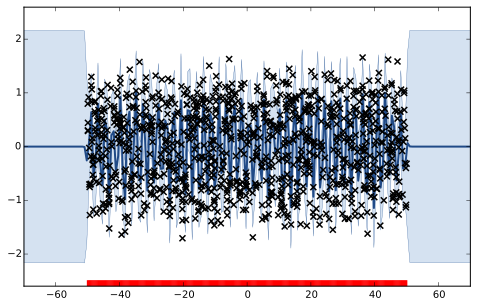

In [7]:
##  find the best hypermaters for FITC  ##
Z = np.linspace(-50.0,50.0,300)[:,None]
m_FITC = gpy.models.SparseGPRegression(x[0:1000],y[0:1000],Z=Z)
m_FITC.inducing_inputs.fix()
m_FITC.optimize_restarts(num_restarts = 10)
m_FITC.plot()
display(m_FITC)

In [14]:
kernel = gpy.kern.RBF(input_dim=1, variance=m_FITC.rbf.variance, lengthscale=m_FITC.rbf.lengthscale)
Z = np.linspace(-50.0,50.0,300)[:,None]
num=[500,1000,1500,2000,2500,3000,3500]
mse_FITC=[]
time_FITC=[]
for i in range(len(num)):
    start_time = time.time()
    m_FITC = gpy.models.SparseGPRegression(X=x[0:num[i]],Y=y[0:num[i]],Z=Z,kernel=kernel)
    time_FITC.append(time.time() - start_time)
    mse_FITC.append((sum((m_FITC.predict(x[0:num[i]])[0]-y[0:num[i]])**2))/num[i])

### 1.4 Final result
As we did last time, we combine the result of three methods above in two plots.

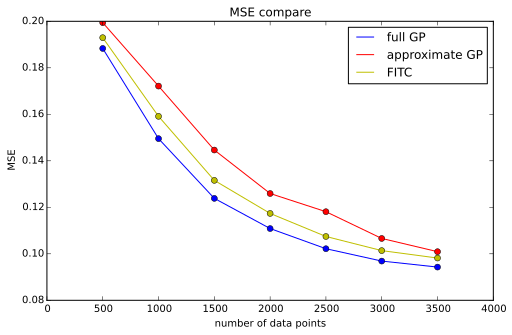

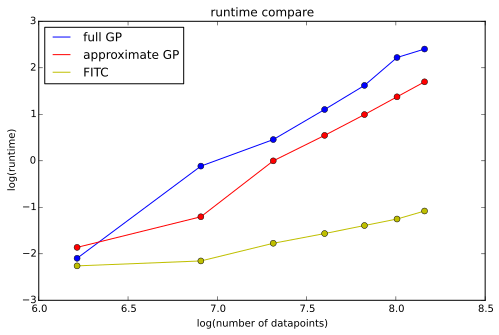

In [18]:
figure()
plot(num,mse_fullGP,'b',label='full GP')
plot(num,mse_fullGP,'bo')
plot(num,mse_SD,'r',label='approximate GP')
plot(num,mse_SD,'ro')
plot(num,mse_FITC,'y',label='FITC')
plot(num,mse_FITC,'yo')
legend()
title('MSE compare')
xlabel('number of data points')
ylabel('MSE')
plt.xlim(0,4000)

figure()
plot(np.log(num),np.log(time_fullGP),'b',label='full GP')
plot(np.log(num),np.log(time_fullGP),'bo')
plot(np.log(num),np.log(time_SD),'r',label='approximate GP')
plot(np.log(num),np.log(time_SD),'ro')
plot(np.log(num),np.log(time_FITC),'y',label='FITC')
plot(np.log(num),np.log(time_FITC),'yo')
legend(loc='upper left')
title('runtime compare')
xlabel('log(number of datapoints)')
ylabel('log(runtime)')

As we can see in the MSE plot, full GP has the smallest MSE. This is because full GP can capture the data very well. The approximate GP has the largest MSE. For the FITC method, its MSE is larger than full GP but is smaller than approximate. In this case, FITC performs very well, and this is also what we expected.

In the runtime plot, we convert both the number of datapoints and runtime to the log scale. We can see that there is linear relationship between log(runtime) and log(number of datapoints). 

In this case, the runtime of FITC is shorter than the runtime of approximate GP, and the MSE of FITC is also smaller than approximate GP. This means FITC is not only more accurate, but also computational efficient. So FITC is a very good method in this case.

### 2. FITC regression using different number of inducing inputs

In FITC method, the number of inducing inputs influences the MSE and runtime. As we increase the number of inducing inputs, the model becomes more accurate while the runtime becomes longer. In this part, we will see how the number of inducing inputs influences the result.

We use 1000 data points, and these 1000 data points are fixed. We use 10,50,100,200,250,300,350 inducing inputs to do FITC respectively, and we also record the MSE and runtime. 

In [30]:
kernel = gpy.kern.RBF(input_dim=1, variance=1.11, lengthscale=0.31)
num_input=[100,150,200,250,300,350]
mse_input=[]
time_input=[]
for i in range(len(num_input)):
    Z = np.linspace(-50.0,50.0,num_input[i])[:,None]
    start_time = time.time()
    m_input = gpy.models.SparseGPRegression(X=x[0:1000],Y=y[0:1000],Z=Z,kernel=kernel)
    time_input.append(time.time() - start_time)
    mse_input.append((sum((m_input.predict(x[0:num[i]])[0]-y[0:num[i]])**2))/num[i])

Then, as we did before, we create the MSE and runtime plot. 

(80, 380)

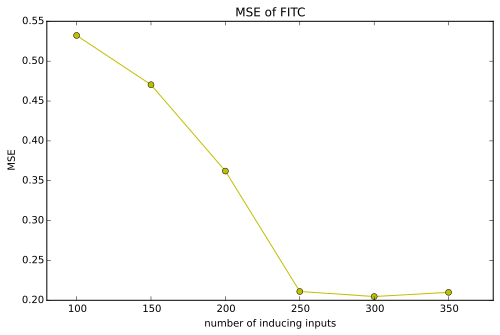

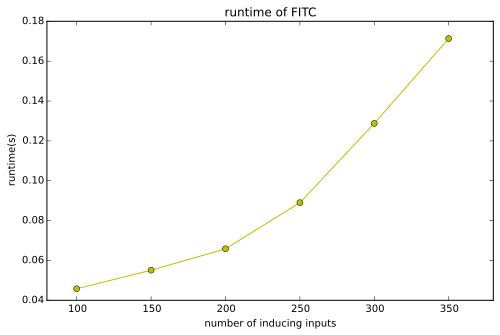

In [35]:
plot(num_input,mse_input,'y',num_input,mse_input,'yo')
title('MSE of FITC')
xlabel('number of inducing inputs')
ylabel('MSE')
plt.xlim(80,380)
figure()
plot(num_input,time_input,'y',num_input,time_input,'yo')
title('runtime of FITC')
xlabel('number of inducing inputs')
ylabel('runtime(s)')
plt.xlim(80,380)

In the MSE plot, as we increase the number of inducing inputs, the MSE keeps decreasing. In the runtime plot, it appears to be a quadratic pattern. This is reasonable because the time complexity of sparse method is $O\left( nm^{2} \right)$. In this case, since we have already fixed the number of datapoints n, so the runtime depends entirely on the inducing inputs. So it should be a quadratic pattern.

### 3. 2-dimensional full GP regression

In this part, we are going to discuss the performance of full GP regression in 2 dimensional case. The function we use is $y=\sin \left( x_{1} \right)+\sin \left( x_{2} \right)$. We create both $x_{1}$ and $x_{2}$ uniformly on the interval [-50,50].

In [3]:
##  create 10000 data points  ##
np.random.seed(100)
x = np.random.uniform(-50.,50.,(10000,2))
y = np.sin(x[:,0:1]) + np.sin(x[:,1:2])+np.random.randn(10000,1)*0.3

### 3.1 Contour plot

We use the RBF kernel with two input dimensions. Then, we can find the optimized parameters and create contour plot


Name                 : GP regression
Log-likelihood       : -1322.86835475
Number of Parameters : 4
Parameters:
  GP_regression.           |       Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |    1.14561596996  |     +ve      |         |         
  rbf.lengthscale          |             (2,)  |     +ve      |         |         
  Gaussian_noise.variance  |  0.0438623984194  |     +ve      |         |         


{'contour': <matplotlib.contour.QuadContourSet instance at 0x1090dd878>,
 'dataplot': <matplotlib.collections.PathCollection at 0x1029c3a10>}

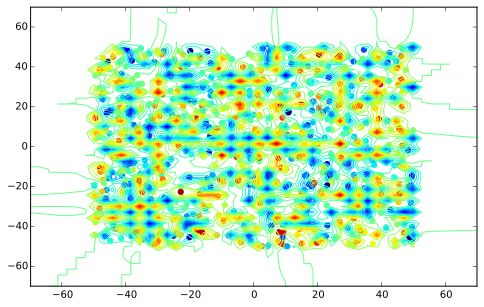

In [4]:
# define kernel
ker = gpy.kern.RBF(2,ARD=True)
# create simple GP model
m = gpy.models.GPRegression(x[0:1000,:],y[0:1000],ker)
# optimize and plot
m.optimize(max_f_eval = 1000)
print(m)
m.plot()

In this contour plot, the contour lines are posterior mean. 

### 3.2 Slices plot

In the contour plot, we can only see the posterior mean. But we don't know the variance. In order to see the uncertainty, we create slices plots. 

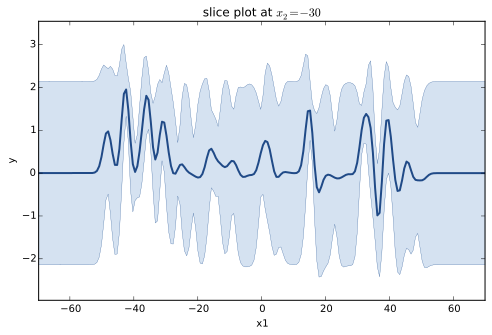

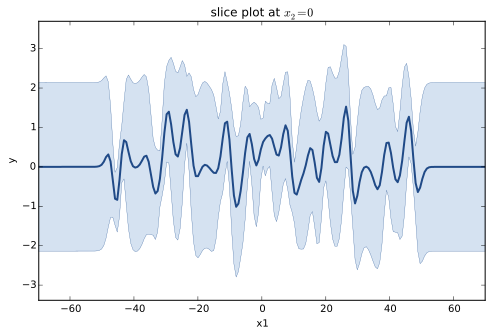

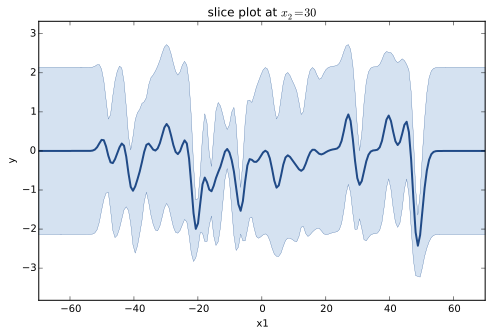

In [35]:
figure
m.plot(fixed_inputs=[(1,-30)], which_data_rows=[])
title('slice plot at $x_{2}=-30$')
xlabel('x1')
ylabel('y')
figure
m.plot(fixed_inputs=[(1,0)], which_data_rows=[])
title('slice plot at $x_{2}=0$')
xlabel('x1')
ylabel('y')
figure
m.plot(fixed_inputs=[(1,30)], which_data_rows=[])
title('slice plot at $x_{2}=30$')
xlabel('x1')
ylabel('y')

The slice plots above are at $x_{2}=-30$,$x_{2}=0$,$x_{2}=30$ respectively. From the slice plot, we can see the variance clearly.

### 3.3 MSE and runtime plot in 2-dimensional case

In this part, we create the MSE and runtime plot in 2-dimensional case.

In [5]:
kernel=gpy.kern.RBF(2,ARD=True,variance=m.rbf.variance[0],lengthscale=m.rbf.lengthscale)
num=[1000,1500,2000,2500,3000,3500]
##  use two vectors to store MSE and time  ##
mse_fullGP=[]
time_fullGP=[]
for i in range(len(num)):
    start_time = time.time()
    m_fullGP = gpy.models.GPRegression(x[0:num[i],:],y[0:num[i]],kernel)
    time_fullGP.append(time.time() - start_time)
    mse_fullGP.append((sum((m_fullGP.predict(x[0:num[i],:])[0]-y[0:num[i]])**2))/num[i])

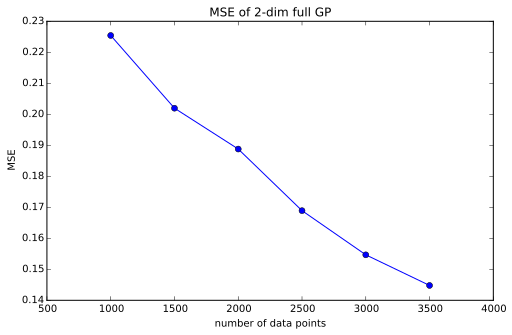

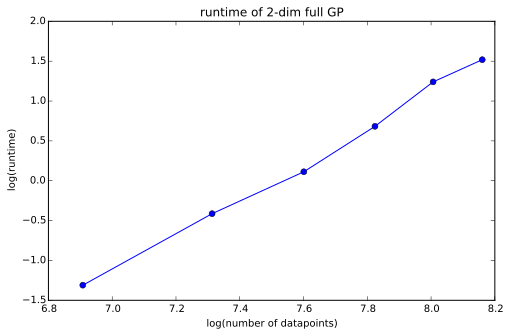

In [6]:
##  create the mse plot for full GP  ##
plot(num,mse_fullGP,num,mse_fullGP,'bo')
title('MSE of 2-dim full GP')
xlabel('number of data points')
ylabel('MSE')
plt.xlim(500,4000)
##  create the runtime plot for full GP  ##
figure()
plot(np.log(num),np.log(time_fullGP),np.log(num),np.log(time_fullGP),'bo')
title('runtime of 2-dim full GP')
xlabel('log(number of datapoints)')
ylabel('log(runtime)')

In the MSE plot, we can see that the MSE in 2-dimensional case is larger than 1-dimensional case. This is because when we draw data from 2 dimension, the data is more scattered than the 1 dimension. For the 2-dimensional case, it is more difficult for GP regression to capture the pattern of data. 